<a href="https://colab.research.google.com/github/andygoosh/crowdanalytix/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import random as rn
import pandas as pd
import xarray
import requests
import datetime

import os
import numpy as np
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import sklearn as skl
import seaborn as sns
import xgboost as xgb
from pathlib import Path
from google.colab import files, drive
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import sklearn

import tensorflow as tf
import tensorflow.keras as keras

print(tf.test.gpu_device_name())
print(tf.__version__)
print(keras.__version__)
print(sklearn.__version__)
#assert ('0.22' == sklearn.__version__)

from keras import layers
from keras.callbacks import TensorBoard
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
if sklearn.__version__ == '0.22':
  from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import sklearn.ensemble

import warnings
warnings.filterwarnings('ignore')
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.6f}'.format

RS = 77
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

GDRIVE_PATH = '/content/drive'
drive.mount(GDRIVE_PATH, force_remount=True)
PATH = os.path.join(GDRIVE_PATH, 'My Drive/crowdanalytix/', '')

Populating the interactive namespace from numpy and matplotlib
TensorFlow 2.x selected.

2.1.0-rc1
2.2.4-tf
0.21.3


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [98]:
df_train = pd.read_csv(os.path.join(PATH, 'CAX_LogFacies_Train_File.csv')) #, dtype={'field1': np.float64, 'field14': np.float64})
df_test = pd.read_csv(os.path.join(PATH, 'CAX_LogFacies_Test_File.csv'), index_col='unique_id') #, dtype={'field1': np.float64, 'field14': np.float64})
df_train.describe()

,row_id,well_id,GR,label
count,4400000.000000,4400000.000000,4400000.000000,4400000.000000
mean,549.500000,1999.500000,109.273256,1.184489
std,317.542553,1154.700634,34.242397,1.465016
min,0.000000,0.000000,-3.181915,0.000000
25%,274.750000,999.750000,81.792217,0.000000
50%,549.500000,1999.500000,120.384935,0.000000
75%,824.250000,2999.250000,134.729051,2.000000
max,1099.000000,3999.000000,197.061419,4.000000


In [100]:
df_test.head()

,row_id,well_id,GR
unique_id,,,
CAX_0,0,5000,113.950000
CAX_1,1,5000,120.896397
CAX_2,2,5000,115.342793
CAX_3,3,5000,118.859190
CAX_4,4,5000,127.735587


In [3]:
df_train.tail()

,row_id,well_id,GR,label
4399995,1095,3999,161.799008,0
4399996,1096,3999,142.631756,0
4399997,1097,3999,142.734504,0
4399998,1098,3999,140.037252,0
4399999,1099,3999,152.400000,0


In [4]:
df_test.describe()

,row_id,well_id,GR
count,2200000.000000,2200000.000000,2200000.000000
mean,549.500000,5999.500000,109.480674
std,317.542589,577.350328,34.247485
min,0.000000,5000.000000,-4.928221
25%,274.750000,5499.750000,82.222922
50%,549.500000,5999.500000,120.568581
75%,824.250000,6499.250000,134.873703
max,1099.000000,6999.000000,196.169026


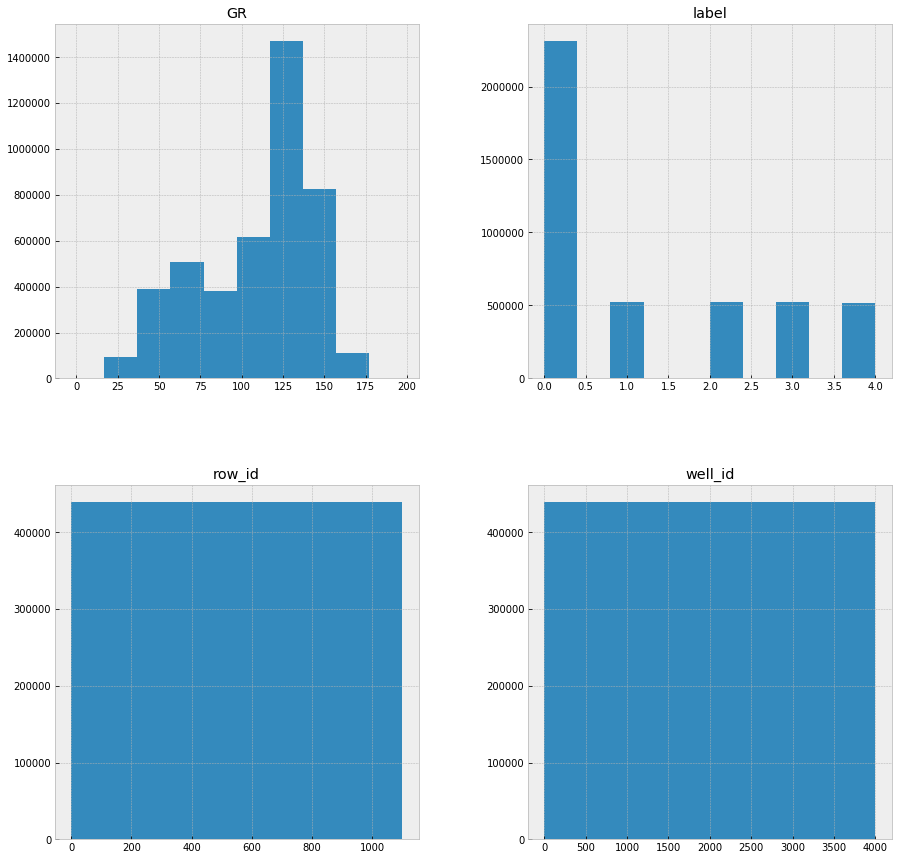

In [5]:
fig, ax = plt.subplots(figsize=(15,15))
df_train.hist(ax=ax);

In [49]:
X = df_train[['label', 'GR']]
X['id'] = df_train['well_id']*1100 + df_train['row_id']

data = pd.DataFrame(X, index=X['id']).drop(['id'], axis=1)
data

,label,GR
id,,
0,0,143.510000
1,0,112.790928
2,0,123.531856
3,0,111.692784
4,0,123.613712
...,...,...
4399995,0,161.799008
4399996,0,142.631756
4399997,0,142.734504


In [0]:
def plot_history(history, metric_names):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  old_rcparam = plt.rcParams["figure.figsize"]
  plt.rcParams["figure.figsize"] = (18,6)

  num_plots = len(metric_names)

  for i in range(num_plots):
    plt.subplot(1,num_plots,i+1)
    plt.xlabel('Epoch')
    plt.ylabel(metric_names[i])
    plt.plot(hist['epoch'], hist[metric_names[i]],
            label='Train %s' % metric_names[i])
    plt.plot(hist['epoch'], hist['val_%s' % metric_names[i]],
            label = 'Val %s' % metric_names[i])
    plt.legend()
  
  plt.show()

  plt.rcParams["figure.figsize"] = old_rcparam

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (1100, 1, 1)              0         
_________________________________________________________________
lstm (LSTM)                  (1100, 256)               264192    
_________________________________________________________________
dense (Dense)                (1100, 5)                 1285      
Total params: 265,477
Trainable params: 265,477
Non-trainable params: 0
_________________________________________________________________
Train on 704000 samples, validate on 176000 samples
Epoch 1/500
704000/704000 [==============================] - 36s 51us/sample - loss: 1.0127 - sparse_categorical_crossentropy: 1.0127 - val_loss: 0.9388 - val_sparse_categorical_crossentropy: 0.9388
Epoch 2/500
704000/704000 [==============================] - 35s 49us/sample - loss: 0.9415 - sparse_categorical_crossentropy: 0.

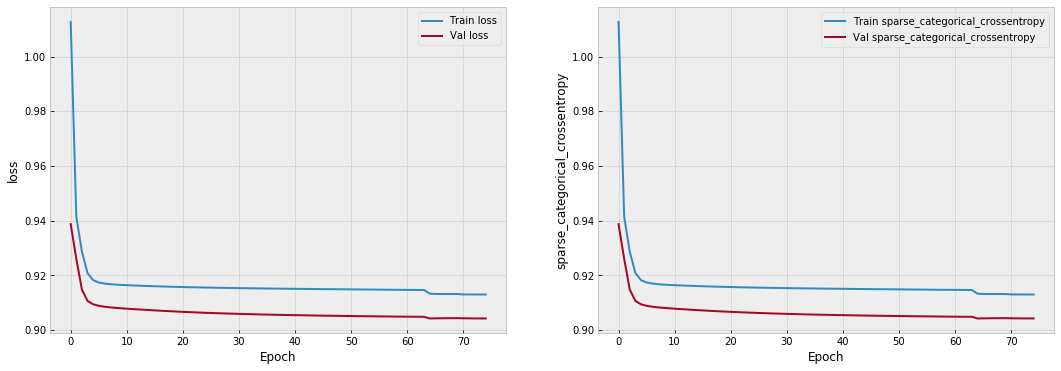

loss: 0.9131 sparse_categorical_crossentropy: 0.9131 


NameError: ignored

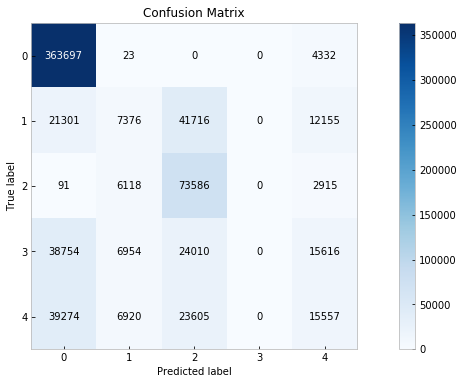

In [85]:
tf.keras.backend.clear_session()

EPOCHS = 500
BS = 1100

X, y = data.iloc[:, 1:], data.iloc[:, :1]
X, _, y, _ = train_test_split(X, y, random_state=RS, shuffle=False, test_size=0.8)
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=False, test_size=0.2)

center, scale = X_train.mean().values, X_train.std().values
X_train = (X_train.values - center)/scale
X_cv = (X_cv.values - center)/scale
y_train = y_train.values.ravel()
y_cv = y_cv.values.ravel()

FEATURES_NUM = X.shape[1]
weight_decay = 0.01
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(FEATURES_NUM,), batch_size=BS),
    tf.keras.layers.Reshape(target_shape=(-1, FEATURES_NUM,)),
    tf.keras.layers.LSTM(256),
    #tf.keras.layers.Dense(512, input_shape=, activation='relu', kernel_regularizer=keras.regularizers.l2(weight_decay)),
    tf.keras.layers.Dense(5, activation='softmax'),
  ])
optimizer=keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, 
              metrics=[#tf.keras.metrics.AUC(), 
                      'sparse_categorical_crossentropy'
                      ], 
              loss='sparse_categorical_crossentropy'
              )

model.reset_states()
model.summary()

class ResetStatesCallback(keras.callbacks.Callback):
    def on_batch_begin(self, batch, logs):
        self.model.reset_states()

lr_schedule = keras.callbacks.ReduceLROnPlateau(verbose=0, factor=0.1, patience=5, monitor='val_loss', mode='min')
early_stop = keras.callbacks.EarlyStopping( patience=10, monitor='val_loss', mode='min' )
model_save = keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True, mode='min' )
reset_states = ResetStatesCallback()

callbacks = [ early_stop, 
        model_save, 
        lr_schedule,
        reset_states
        ]

history = model.fit(X_train, y_train,
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          use_multiprocessing=True,
          verbose=1,
          validation_data=(X_cv, y_cv),
          callbacks=callbacks)

model = keras.models.load_model('my_checkpoint.h5')

plot_history(history, model.metrics_names)

score = model.evaluate(X_train, y_train, 
                        batch_size=BS, 
                        verbose=0,
                        use_multiprocessing=True)

metrics = ''
for i in range(len(model.metrics_names)):
  metrics += f'{model.metrics_names[i]}: {score[i]:.4f} '

print(metrics)

fname = os.path.join(PATH, 'result.txt')
with open(fname, 'w') as text_file:
  print(metrics, file=text_file)

model.reset_states()

train_pred_proba = model.predict(X_train, use_multiprocessing=True)
train_pred = train_pred_proba.argmax(axis=1)
cv_pred_proba = model.predict(X_cv, use_multiprocessing=True)
cv_pred = cv_pred_proba.argmax(axis=1)

import scikitplot as skplt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
skplt.metrics.plot_confusion_matrix(y_train, train_pred, ax=ax1)
skplt.metrics.plot_confusion_matrix(y_cv, cv_pred, ax=ax2)
ax1.set_title("Train")
ax2.set_title("CV")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
skplt.metrics.plot_roc(y_train, train_pred_proba, ax=ax1)
skplt.metrics.plot_roc(y_cv, cv_pred_proba, ax=ax2)
ax1.set_title("Train")
ax2.set_title("CV")

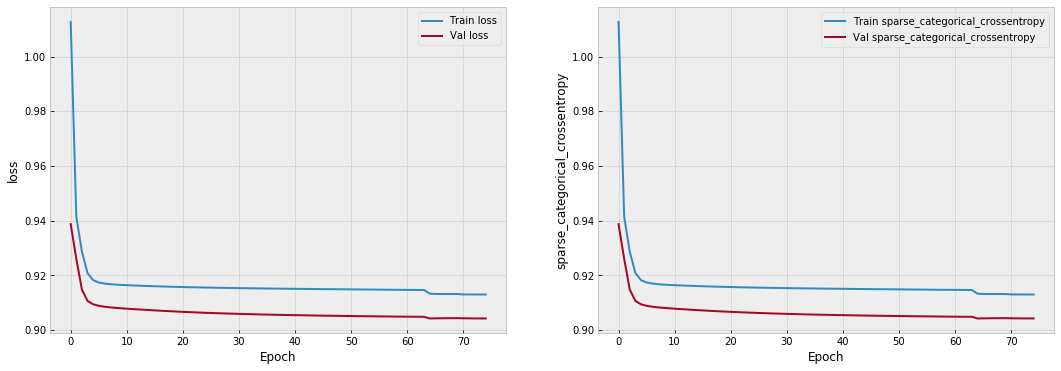

loss: 0.9131 sparse_categorical_crossentropy: 0.9131 


Text(0.5, 1.0, 'CV')

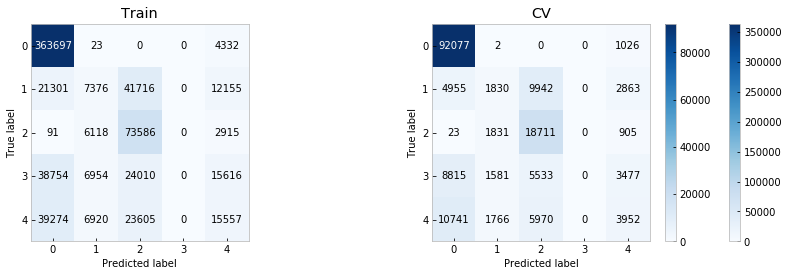

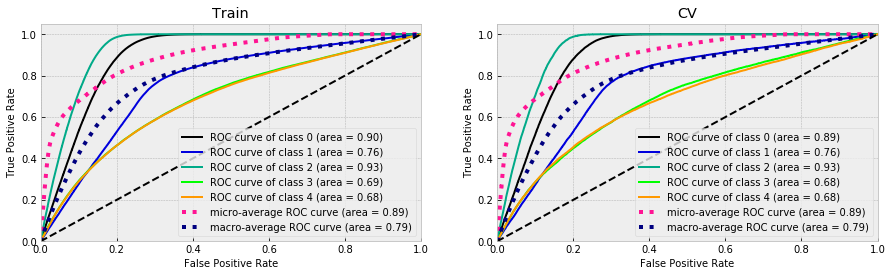

In [96]:
model = keras.models.load_model('my_checkpoint.h5')

plot_history(history, model.metrics_names)

score = model.evaluate(X_train, y_train, 
                        batch_size=BS, 
                        verbose=0,
                        use_multiprocessing=True)

metrics = ''
for i in range(len(model.metrics_names)):
  metrics += f'{model.metrics_names[i]}: {score[i]:.4f} '

print(metrics)

fname = os.path.join(PATH, 'result.txt')
with open(fname, 'w') as text_file:
  print(metrics, file=text_file)

model.reset_states()

train_pred_proba = model.predict(X_train, use_multiprocessing=True)
train_pred = train_pred_proba.argmax(axis=1)
cv_pred_proba = model.predict(X_cv, use_multiprocessing=True)
cv_pred = cv_pred_proba.argmax(axis=1)

import scikitplot as skplt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
skplt.metrics.plot_confusion_matrix(y_train, train_pred, ax=ax1)
skplt.metrics.plot_confusion_matrix(y_cv, cv_pred, ax=ax2)
ax1.set_title("Train")
ax2.set_title("CV")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
skplt.metrics.plot_roc(y_train, train_pred_proba, ax=ax1)
skplt.metrics.plot_roc(y_cv, cv_pred_proba, ax=ax2)
ax1.set_title("Train")
ax2.set_title("CV")

In [0]:
X_test = df_test[['GR']]
X_test = (X_test.values - center)/scale

test_pred_proba = model.predict(X_test, use_multiprocessing=True)
test_pred = test_pred_proba.argmax(axis=1)

df_test_pred=pd.DataFrame(test_pred, index=df_test.index, columns=['label']).to_csv('submission.csv')
df_test_pred

In [87]:
!pip3 install scikit-plot